# Vision

**Summary:** In this tutorial, we will build a simple model to control the fly to follow a moving sphere. By doing so, we will also demonstrate how one can create a custom arena.

Animals typically navigate over rugged terrain to reach attractive objects (e.g. potential mates, food sources) and to avoid repulsive features (e.g. pheromones from predators) and obstacles. Animals use a hierarchical controller to achieve these goals: processing higher-order sensory signals, using them to select the next action, and translating these decisions into descending commands that drive lower-level motor systems. We aimed to simulate this sensorimotor hierarchy by adding vision and olfaction to NeuroMechFly.

## Retina simulation

A fly’s compound eye consists of ∼700–750 individual units called ommatidia arranged in a hexagonal pattern (see the left panel of the figure below from the [droso4schools project](https://droso4schools.wordpress.com/l4-enzymes/#5); see also [this article](https://azretina.sites.arizona.edu/node/789) from the Arizona Retina Project). To emulate this, we attached a color camera to each of our model’s compound eyes (top right panel). We then transformed each camera image into 721 bins, representing ommatidia. Based on previous studies, we assume a 270° combined azimuth for the fly’s field of view, with a ∼17° binocular overlap. Visual sensitivity has evolved to highlight ethologically relevant color spectra at different locations in the environment. Here, as an initial step toward enabling this heterogeneity in our model, we implemented yellow- and pale-type ommatidia—sensitive to the green and blue channels of images rendered by the physics simulator—randomly assigned at a 7:3 ratio (as reported in [Rister et al, 2013](https://pubmed.ncbi.nlm.nih.gov/23293281/)). Users can substitute the green and blue channel values with the desired light intensities sensed by yellow- and pale-type ommatidia to achieve more biorealistic chromatic vision.

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/vision.png?raw=true" alt="rule_based" width="800"/>

In NeuroMechFly, the main interface to interact with the fly is the [Retina class](https://neuromechfly.org/api_ref/vision.html#retina-simulation). It is embedded into the `NeuroMechFly` class as its `.retina` attribute if `enable_vision` is set to True in `NeuroMechFly.sim_params`. Here, let's reproduce the top right panel of the figure above by putting the fly into an arena with three pillars and simulating the fly's visual experience.

To start, we do the necessary imports:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env

from flygym import Fly, Camera
from flygym.arena import FlatTerrain
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym.examples.turning_controller import HybridTurningNMF

/Users/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/Users/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


In [3]:
from pathlib import Path

Path("./outputs").mkdir(exist_ok=True)

We have pre-implemented an `ObstacleOdorArena` class with visual obstacles and an odor source. The details of this class is beyond the scope of this tutorial, but you can refer to it on the [FlyGym github repository](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/examples/obstacle_arena.py):

In [4]:
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

Let's put the fly in it and simulate 500 timesteps so the fly can stand on the floor in a stable manner:

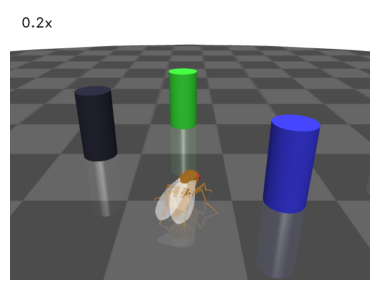

In [5]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    spawn_pos=(13, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)

cam = Camera(fly=fly, play_speed=0.2, camera_id="user_cam")
sim = HybridTurningNMF(fly=fly, cameras=[cam], arena=arena)

for i in range(500):
    obs, reward, terminated, truncated, info = sim.step(np.zeros(2))
    sim.render()

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig("./outputs/vision_sim_env.png")

We can access the intensities sensed by the fly's ommatidia from the observation:

In [6]:
print(obs["vision"])
print("Shape:", obs["vision"].shape)
print("Data type:", obs["vision"].dtype)

[[[0.9913793  0.        ]
  [1.         0.        ]
  [1.         0.        ]
  ...
  [0.29803923 0.        ]
  [0.29803923 0.        ]
  [0.29803923 0.        ]]

 [[0.9913793  0.        ]
  [1.         0.        ]
  [1.         0.        ]
  ...
  [0.4        0.        ]
  [0.4        0.        ]
  [0.4        0.        ]]]
Shape: (2, 721, 2)
Data type: float32


This gives us a (2, 721, 2) array representing the light intensities sensed by the ommatidia. The values are normalized to [0, 1]. The first dimension is for the two eyes (left and right in that order). The second dimension is for the 721 ommatidia per eye. The third dimension is for the two color channels (yellow- and pale-type in that order). For each ommatidia, only one of the two numbers along the last dimension is nonzero. The yellow- and pale-type ommatidia are split at a 7:3 ratio. We can verify this below:

In [7]:
nonzero_idx = np.nonzero(obs["vision"])
unique_vals, val_counts = np.unique(nonzero_idx[2], return_counts=True)
val_counts / val_counts.sum()

array([0.70041609, 0.29958391])

But this is array representation is not good for visualization. We can use the `hex_pxls_to_human_readable` method of the retina to convert it into a normal [0, 256) 8-bit RGB image that can be plotted. We set `color_8bit` to True to process the 8-bit color representation more efficiently and to return the output as an integer ranged from 0 to 255. We will further take the grayscale image (disregard yellow- vs pale-type ommatidia) by taking the maximum along the last dimension, i.e. that of color channels.

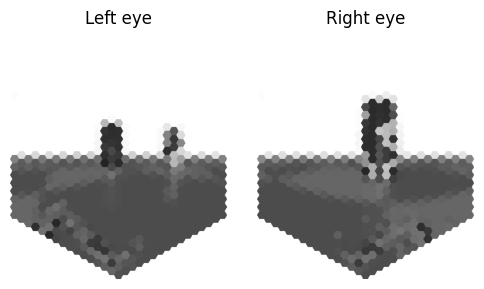

In [8]:
vision_left = fly.retina.hex_pxls_to_human_readable(
    obs["vision"][0, :, :], color_8bit=True
)
vision_left = vision_left.max(axis=-1)
vision_right = fly.retina.hex_pxls_to_human_readable(
    obs["vision"][1, :, :], color_8bit=True
)
vision_right = vision_right.max(axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(vision_left, cmap="gray", vmin=0, vmax=255)
axs[0].axis("off")
axs[0].set_title("Left eye")
axs[1].imshow(vision_right, cmap="gray", vmin=0, vmax=255)
axs[1].axis("off")
axs[1].set_title("Right eye")
fig.savefig("./outputs/vision_sim.png")

Since `render_raw_vision` is set to True in the parameters, we can access the raw RGB vision through the `info` dictionary before pixels are binned into ommatidia: 

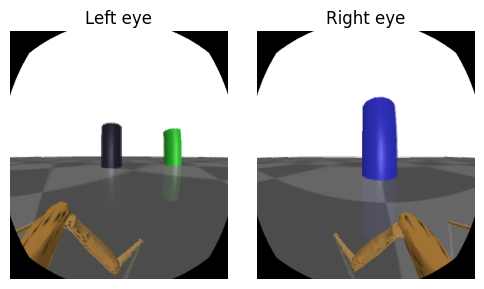

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(info["raw_vision"][0, :, :, :].astype(np.uint8))
axs[0].axis("off")
axs[0].set_title("Left eye")
axs[1].imshow(info["raw_vision"][1, :, :, :].astype(np.uint8))
axs[1].axis("off")
axs[1].set_title("Right eye")
fig.savefig("./outputs/vision_sim_raw.png")

We observe that the ommatidia covering the blue and the green pillars seem to have a bimodal distribution in intensity. This is because the ommatidia are stochastically split into yellow- and pale-types, and they have different sensitivities to different colors.

## A dynamic arena with a moving sphere

The next step is to create a custom arena with a moving sphere. To do this, we will implement a `MovingObjArena` class that inherits from the `flygym.arena.BaseArena` class. A complete, functioning implementation of this class is provided under `flygym.examples.vision` on the [FlyGym repository](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/examples/vision.py). We start by defining some attributes in its `__init__` method:

```Python
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_direction : str
        Which way the ball moves toward first. Can be "left", "right", or
        "random".
    move_speed : float
        Speed of the moving object.
    """

    def __init__(
        self,
        size: Tuple[float, float] = (300, 300),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 1,
        init_ball_pos: Tuple[float, float] = (5, 0),
        move_speed: float = 8,
        move_direction: str = "right",
    ):
        super().__init__()
        
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")
    
        ...
```

Next, we define a `root_element` attribute. The simulated world is represented as a tree of objects, each attached to a parent. For example, the eyes of the fly are attached to the head, which is in turn attached to the thorax — the base of the NeuroMechFly model. Note that this tree is merely a representation of objects and their relation to each other; there does not necessarily have to be a visual or anatomical link between the parent and child objects. For example, the base of the NeuroMechFly model — the thorax — is attached to the world, but the link between the thorax and the world is a free joint, meaning that it is free to move in all 6 degrees of freedom. The root element is the root of this tree.

```Python
        ...

        self.root_element = mjcf.RootElement()

        ...
```

Then, we will add the moving sphere. It will be attached to the root element:

```Python
        ...
        
        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        ...
```

Let's also add some cameras so we can visualize the scene from different angles. This concludes the definition of our `__init__` method.

```Python
        ...

        # Add camera
        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(15, 0, 35),
            euler=(0, 0, 0),
            fovy=45,
        )
        self.birdeye_cam_zoom = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam_zoom",
            mode="fixed",
            pos=(15, 0, 20),
            euler=(0, 0, 0),
            fovy=45,
        )
```

Next, let's define a `get_spawn_position` class. This is applies an offset to the user-defined fly spawn position. For example, if there is a stage in your arena that is 1 mm high, and you want to place the fly on this stage, then you might want to apply a transformation to the user-specified relative spawn position and return `rel_pos + np.array([0, 0, 1])` as the effective spawn position. In our case, we have a flat arena, so we will just return the spawn position and orientation as is:

```Python
    def get_spawn_position(self, rel_pos, rel_angle):
        return rel_pos, rel_angle
```

The arena also has a `step` method. Usually, in static arenas, this is left empty. However, since we want the sphere to move in our arena, we need to implement this method so the sphere is moved appropriately every step of the simulation:

```Python
    def step(self, dt, physics):
        heading_vec = np.array([1, 2 * np.cos(self.curr_time * 3) * self.y_mult])
        heading_vec /= np.linalg.norm(heading_vec)
        self.ball_pos[:2] += self.move_speed * heading_vec * dt
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt
```

Finally, let's implement a `reset` method:

```Python
    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos
```

## Visual feature preprocessing

We will preprocess the visual feature by computing the x-y position of the object on the retina along with its size relative to the whole retinal image. We do this by applying binary thresholding to the image and calculating its size and center of mass. This is a good example to once again showcase the benefit of encapsulating preprogrammed logic into the Markov Decision Process (implemented as a Gym environment). If you haven't, read the tutorial on [building a turning controller](https://neuromechfly.org/tutorials/turning.html) to see how this is done.

Recall that in the `HybridTurningController`, we implemented the purple arrow in the following figure, encapsulating the CPG network and the sensory feedback-based correction rules:

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true" alt="rule_based" width="500"/>

Here, we will build yet another layer on top of `HybridTurningController`, implementing the aforementioned sensory preprocessing logic (cyan arrow) and encapsulating it inside the new MDP. As before, a complete, functioning implementation of this class is provided under `flygym.examples.vision` on the [FlyGym repository](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/examples/vision.py).

We start by defining an `__init__` method. This time, we will specify the threshold used in the binary thresholding step. Any pixel darker than this number will be considered part of the black sphere. We will also define a decision interval $\tau$: the turning signal is recomputed every $\tau$ seconds. We will compute the center of mass (COM) of all ommatidia so that later when we need to compute the COM of the object (a masked subset of pixels), we can simply take the average of the COMs of the selected pixels. Finally, we will override the definition of the observation space with a 6-dimensional one (x, y positions of the object per side, plus the relative size of the object per side).

```Python
class VisualTaxis(HybridTurningNMF):
    def __init__(self, obj_threshold=0.15, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs)

        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.retina.num_ommatidia_per_eye, 2))
        for i in range(self.retina.num_ommatidia_per_eye):
            mask = self.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)
        
        self.observation_space = spaces.Box(0, 1, shape=(6,))
```

Next, let's implement the visual preprocessing logic discussed above:

```Python
    def _process_visual_observation(self, raw_obs):
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= self.retina.nrows  # normalize y_center
        features[:, 1] /= self.retina.ncols  # normalize x_center
        features[:, 2] /= self.retina.num_ommatidia_per_eye  # normalize area
        return features.ravel()
```

In the `step` method, we will replace the raw observation with the output of the `_process_visual_observation` method. We will also record the retina images every time the simulation renders a frame for the recorded video. This way, we can visualize the retina images along with the recorded video later:

```Python
    def step(self, control_signal):
        for _ in range(self.num_substeps):
            raw_obs, _, _, _, _ = super().step(control_signal)
            render_res = super().render()
            if render_res is not None:
                # record visual inputs too because they will be played in the video
                self.visual_inputs_hist.append(raw_obs["vision"].copy())
        visual_features = self._process_visual_observation(raw_obs)
        return visual_features, 0, False, False, {}
```

Finally, we implement the `reset` method:

```Python
    def reset(self, seed=0, **kwargs):
        raw_obs, _ = super().reset(seed=seed)
        return self._process_visual_observation(raw_obs), {}
```

## Implementing a object tracking controller

Now that we have implemented the arena and the new Gym environment, we just need to define the actual controller logic that outputs the 2D descending representation based on the extracted visual features. As a proof-of-concept, we have hand-tuned the following relationship:

$$
\delta_i = \begin{cases}
\min(\max(k a_i + b, \delta_\text{min}), \delta_\text{max})   & \text{if } A_i > A_\text{thr} \\
1  & \text{otherwise}
\end{cases}
$$

where $\delta_i$ is the descending modulation signal on side $i$; $a_i$ is the azimuth of the object expressed as the deviation from the anterior edge of the eye's field of view, normalized by the horizontal field of view of the retina; $A_i$ is the relative size of the object on the arena; $k=-3$, $b=1$ are parameters describing the response curve; $\delta_\text{min}=0.2$, $\delta_\text{max}=1$ describe the range of the descending signal; $A_\text{thr} = 1\%$ is the threshold below which the object is considered unseen from the eye.

Before we implement this in the main simulation loop, let's instantiate our arena and Gym environment:

In [10]:
from flygym.examples.vision import MovingObjArena, VisualTaxis

obj_threshold = 0.2
decision_interval = 0.025
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
arena = MovingObjArena()
fly = Fly(
    contact_sensor_placements=contact_sensor_placements,
    enable_adhesion=True,
    enable_vision=True,
)
cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)
sim = VisualTaxis(
    fly=fly,
    camera=cam,
    obj_threshold=obj_threshold,
    decision_interval=decision_interval,
    arena=arena,
    intrinsic_freqs=np.ones(6) * 9,
)

As before, let's check if this environment complies with the Gym interface. Despite a few warnings on design choices, no errors should be raised.

In [11]:
check_env(sim)

/Users/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/gymnasium/utils/env_checker.py:247: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
/Users/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/gymnasium/utils/env_checker.py:125: UserWarning: WARN: The default seed argument in reset should be `None`, otherwise the environment will by default always be deterministic. Actual default: 0
  logger.warn(
/Users/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed=0
  logger.warn(
/Users/tlam/miniconda3/envs/flygym/lib/python3.11/site-packages/gymnasium/utils/env_checker.py:321: UserW

Now, we implement the main simulation loop:

In [12]:
def calc_ipsilateral_speed(deviation, is_found):
    if not is_found:
        return 1.0
    else:
        return np.clip(1 - deviation * 3, 0.4, 1.2)


num_substeps = int(decision_interval / sim.timestep)

obs_hist = []
deviations_hist = []
control_signal_hist = []

obs, _ = sim.reset()
for i in trange(140):
    left_deviation = 1 - obs[1]
    right_deviation = obs[4]
    left_found = obs[2] > 0.01
    right_found = obs[5] > 0.01
    if not left_found:
        left_deviation = np.nan
    if not right_found:
        right_deviation = np.nan
    control_signal = np.array(
        [
            calc_ipsilateral_speed(left_deviation, left_found),
            calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

    obs, _, _, _, _ = sim.step(control_signal)
    obs_hist.append(obs)
    deviations_hist.append([left_deviation, right_deviation])
    control_signal_hist.append(control_signal)

100%|██████████| 140/140 [01:36<00:00,  1.45it/s]


To inspect the recorded video:

In [13]:
cam.save_video("./outputs/object_following.mp4")

We can use the `save_video_with_vision_insets` utility function to regenerate this video, but with insets at the bottom illustrating the visual experience of the fly:

In [14]:
from flygym.vision.visualize import save_video_with_vision_insets

save_video_with_vision_insets(
    sim,
    cam,
    "./outputs/object_following_with_retina_images.mp4",
    sim.visual_inputs_hist,
)